In [2496]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from types import *
import matplotlib.animation as animation
from matplotlib import rc
import pandas as pd
import matplotlib.pyplot as plt


In [2497]:
#model variables
#x1 = gene (DNA) ON
#x2 = gene (DNA) OFF
#x3 = nascent RNA
#x4 = mRNA nuclei
#x5 = mRNA cytoplasm
#x6 = protein

#Reactions
#R1 = Gene activation
#R2 = Gene deactivation
#R3 = Nascent RNA
#R4 = mature mRNA
#R5 = mRNA Nuclear degradation
#R6 = mRNA transport to cytoplasm
#R7 = mRNA Cytoplasmic degradation
#R8 = mRNA Cytoplasmic Translation
#R9 = protein Degradation

#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate


In [2498]:
# Set up for inline animations in Jupyter
rc('animation', html='jshtml')

# Function to compute the time of the next reaction
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Function to compute the index of the next reaction
def next_reaction(x, t, W, pars, di, ti):
    W_vals = W(x, t, pars=pars, di=di, ti=ti)
    W0 = np.sum(W_vals)
    r = np.random.rand()
    i = 0
    W_sum = W_vals[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W_vals[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        return np.array(times), np.array(states)
    else:
        return x
    
def dxdt(x, t, pars, di, ti, drugNumber):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti, drugNumber)).flatten()
    return y

def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti, drugNumber))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while k < len(t) and times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(f'{path}/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(f'{path}/Drug{drug_number}_{drug_conc}nM_DesignResults.csv')

    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros((5, len(t)))
    data_std = np.zeros((5, len(t)))
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])
        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])
    plt.show()

#Hill function
def hill_function(concentration, Kd, n):
    return Kd**n / (Kd**n + concentration**n)

def hillNegative_function(concentration, Kd, n):
    return Kd**n / (Kd**n + concentration**n)

def hillPositive_function(concentration, Kd, n):
    return concentration**n / (Kd**n + concentration**n)

def W(x, t, pars, di, ti, drugNumber):
        #drug_concentration = di[1] if t > ti[1] else 0
        
        if drugNumber == 0:
            Kd = 0
            n = 0

            W = [
            pars['k1'] * x[1],  # R1: Gene activation
            pars['k2'] * x[0],  # R2: Gene deactivation
            pars['k3'] * x[0],  # R3: Nascent RNA synthesis
            pars['k4'] * x[2],  # R4: Mature mRNA synthesis
            pars['k5'] * x[3],  # R5: mRNA nuclear degradation
            pars['k6'] * x[3],  # R6: mRNA transport to cytoplasm
            pars['k7'] * x[4],  # R7: mRNA cytoplasmic degradation
            pars['k8'] * x[4],  # R8: mRNA cytoplasmic translation
            pars['k9'] * x[5],  # R9: Protein degradation
            pars['k10'] * x[2]  # R10: Nascent RNA degradation
            ]
            return np.array(W)
        
        elif drugNumber == 2:
            Kd = pars['Kd2']
            n = pars['n2']

            # Calculate the effect of the drug using the Hill function
            hill_effect = hillNegative_function(di[1], Kd, n)

            W = [
            pars['k1'] * x[1],  # R1: Gene activation
            pars['k2'] * x[0],  # R2: Gene deactivation
            pars['k3'] * x[0],  # R3: Nascent RNA synthesis
            pars['k4'] * x[2],  # R4: Mature mRNA synthesis
            pars['k5'] * x[3],  # R5: mRNA nuclear degradation
            pars['k6'] * x[3] * ((t < ti[1]) + hill_effect * (t >= ti[1])),  # R6: mRNA transport to cytoplasm
            pars['k7'] * x[4],  # R7: mRNA cytoplasmic degradation
            pars['k8'] * x[4],  # R8: mRNA cytoplasmic translation
            pars['k9'] * x[5],  # R9: Protein degradation
            pars['k10'] * x[2]  # R10: Nascent RNA degradation
            ]
            return np.array(W)
        
        elif drugNumber == 4:
            Kd = pars['Kd4']
            n = pars['n4']

            # Calculate the effect of the drug using the Hill function
            hill_effect = hillNegative_function(di[1], Kd, n)

            W = [
            pars['k1'] * x[1],  # R1: Gene activation
            pars['k2'] * x[0],  # R2: Gene deactivation
            pars['k3'] * x[0],  # R3: Nascent RNA synthesis
            pars['k4'] * x[2],  # R4: Mature mRNA synthesis
            pars['k5'] * x[3],  # R5: mRNA nuclear degradation
            pars['k6'] * x[3],  # R6: mRNA transport to cytoplasm
            pars['k7'] * x[4],  # R7: mRNA cytoplasmic degradation
            pars['k8'] * x[4] *  ((t < ti[1]) + hill_effect * (t >= ti[1])),  # R8: mRNA cytoplasmic translation
            pars['k9'] * x[5],  # R9: Protein degradation
            pars['k10'] * x[2]  # R10: Nascent RNA degradation
            ]
            return np.array(W)
        
        elif drugNumber == 6:
            Kd = pars['Kd6']
            n = pars['n6']

            # Calculate the effect of the drug using the Hill function
            hill_effect = hillNegative_function(di[1], Kd, n)

            W = [
            pars['k1'] * x[1],  # R1: Gene activation
            pars['k2'] * x[0],  # R2: Gene deactivation
            pars['k3'] * x[0] *  ((t < ti[1]) + hill_effect * (t >= ti[1])),  # R3: Nascent RNA synthesis
            pars['k4'] * x[2],  # R4: Mature mRNA synthesisu 
            pars['k5'] * x[3],  # R5: mRNA nuclear degradation
            pars['k6'] * x[3],  # R6: mRNA transport to cytoplasm
            pars['k7'] * x[4],  # R7: mRNA cytoplasmic degradation
            pars['k8'] * x[4],  # R8: mRNA cytoplasmic translation
            pars['k9'] * x[5],  # R9: Protein degradation
            pars['k10'] * x[2]  # R10: Nascent RNA degradation
            ]
            return np.array(W)
        
        elif drugNumber == 7:
            Kd = pars['Kd7']
            n = pars['n7']

            # Calculate the effect of the drug using the Hill function
            hill_effect = hillPositive_function(di[1], Kd, n)

            W = [
            pars['k1'] * x[1],  # R1: Gene activation
            pars['k2'] * x[0],  # R2: Gene deactivation
            pars['k3'] * x[0],  # R3: Nascent RNA synthesis
            pars['k4'] * x[2],  # R4: Mature mRNA synthesis
            pars['k5'] * x[3] / ((t < ti[1]) + hill_effect * (t >= ti[1])),  # R5: mRNA nuclear degradation
            pars['k6'] * x[3],  # R6: mRNA transport to cytoplasm
            pars['k7'] * x[4],  # R7: mRNA cytoplasmic degradation
            pars['k8'] * x[4],  # R8: mRNA cytoplasmic translation
            pars['k9'] * x[5],  # R9: Protein degradation
            pars['k10'] * x[2]  # R10: Nascent RNA degradation
            ]
            return np.array(W)
        
        elif drugNumber == 10:
            Kd = pars['Kd10']
            n = pars['n10']

            # Calculate the effect of the drug using the Hill function
            hill_effect = hillPositive_function(di[1], Kd, n)

            W = [
            pars['k1'] * x[1],  # R1: Gene activation
            pars['k2'] * x[0],  # R2: Gene deactivation
            pars['k3'] * x[0],  # R3: Nascent RNA synthesis
            pars['k4'] * x[2],  # R4: Mature mRNA synthesis
            pars['k5'] * x[3],  # R5: mRNA nuclear degradation
            pars['k6'] * x[3],  # R6: mRNA transport to cytoplasm
            pars['k7'] * x[4],  # R7: mRNA cytoplasmic degradation
            pars['k8'] * x[4],  # R8: mRNA cytoplasmic translation
            pars['k9'] * x[5] / ((t < ti[1]) + hill_effect * (t >= ti[1])) ,  # R9: Protein degradation
            pars['k10'] * x[2]  # R10: Nascent RNA degradation
            ]
            return np.array(W)
        print(W)
               


In [2499]:
# Updated stoichiometry matrix
S = np.array([
    [1, -1,  0,  0,  0,  0,  0,  0,  0, 0],  # gene ON (x1)
    [-1,  1,  0,  0,  0,  0,  0,  0,  0, 0],  # gene OFF (x2)
    [0,  0,  1, -1,  0,  0,  0,  0,  0, -1],  # nascent RNA (x3)
    [0,  0,  0,  1, -1, -1,  0,  0,  0, 0],  # mRNA nuclei (x4)
    [0,  0,  0,  0,  0,  1, -1,  0,  0, 0],  # mRNA cytoplasm (x5)
    [0,  0,  0,  0,  0,  0,  0,  1, -1, 0]   # protein (x6)
])
# K1 = 1.5
# n1 = 0.8

# K2 = 2
# n2 = 2.5

# # Hill functions
# def hillPositive(x, K=K1, n=n1):
#     return x**n / (K**n + x**n)

# def hillNegative(x, K=K2, n=n2):
#     return K**n / (K**n + x**n)


# Parameters
pars = {
    'k1': 0.01, 'k2': 0.01, 'k3': 0.125, 'k4': 0.08, 'k5': 0.03,
    'k6': 0.08, 'k7': 0.045, 'k8': 0.48, 'k9': 0.005, 'k10': 0.01, 
    'Kd2': 1050, 'n2': 50,
    'Kd4': 1250, 'n4': 7, 
    'Kd6': 1700, 'n6': 10, 
    'Kd7': 1300, 'n7': 15, 
    'Kd10': 1300, 'n10': 6.5}

#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate
#k10 = nascent RNA degradation rate

# Initial conditions
x0 = np.array([1, 0, 6, 5, 8.5, 770])
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein
pars = {
    'k1': 0.01, 'k2': 0.01, 'k3': 1, 'k4': 0.08, 'k5': 0.03,
    'k6': 0.08, 'k7': 0.045, 'k8': 0.48, 'k9': 0.005, 'k10': 0.002, 
    'Kd2': 400, 'n2': 2.1,
    'Kd4': 550, 'n4': 2, 
    'Kd6': 5, 'n6': 2, 
    'Kd7': 1.3, 'n7': -0.8, 
    'Kd10': 0.9, 'n10': -0.3}


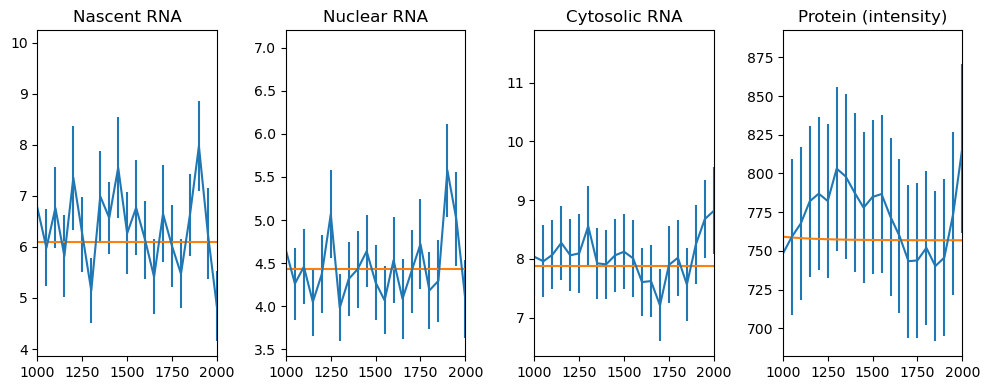

In [2500]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,1000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 0 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)


## DRUG 2

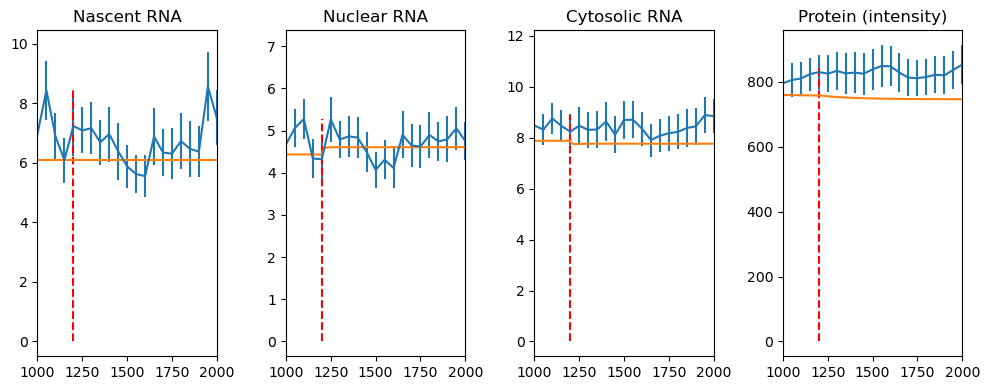

In [2501]:

# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,100,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 2 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, drug_conc=100, path=pathName, model='ODE', ntraj=10)

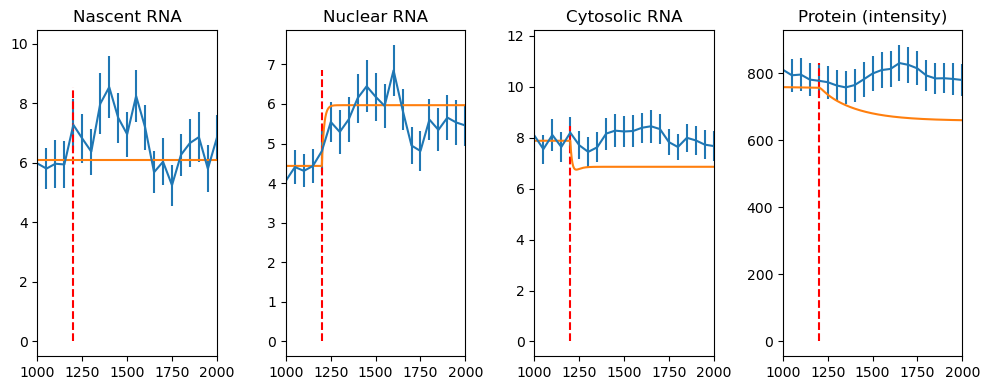

In [2502]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,300,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 2 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict,drug_conc=300, path=pathName, model='ODE', ntraj=10)

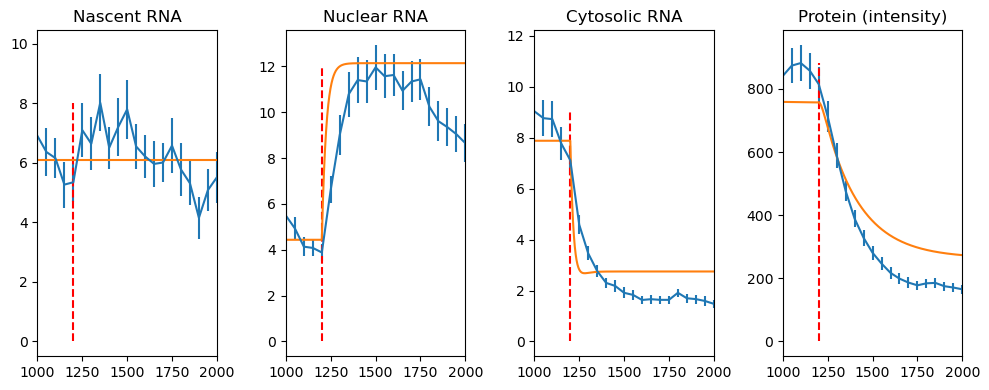

In [2503]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,1000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 2 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict,drug_conc=1000, path=pathName, model='ODE', ntraj=10)

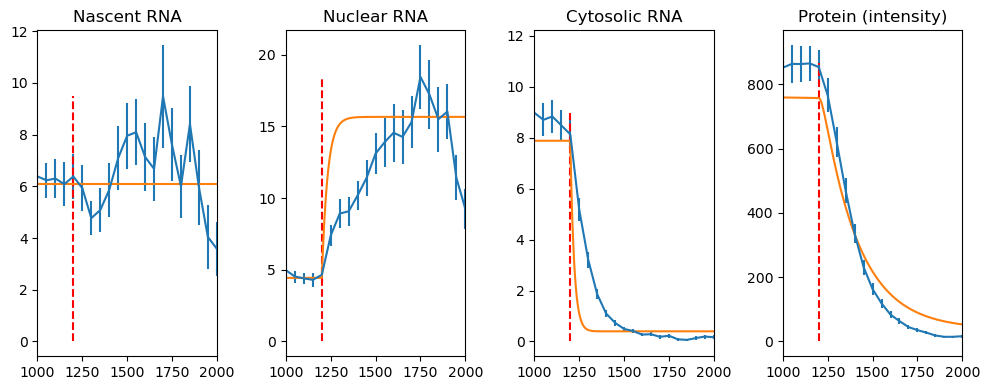

In [2504]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,3000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 2 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10, drug_conc=3000)

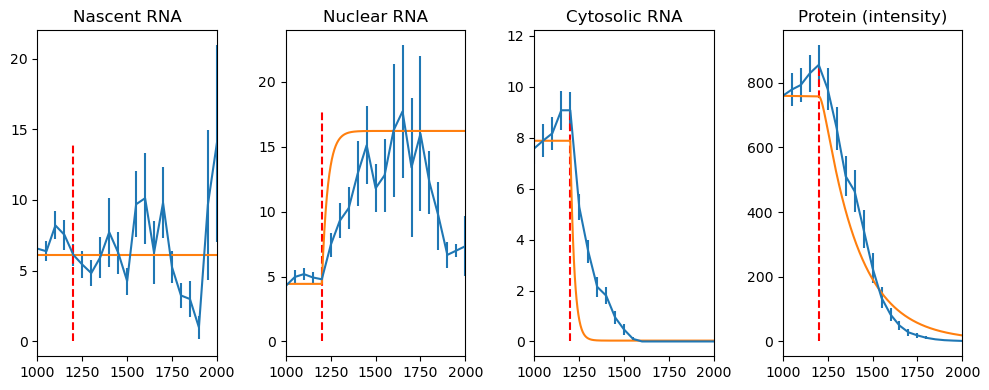

In [2505]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,10000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 2 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName,drug_conc=10000, model='ODE', ntraj=10)

## DRUG 4

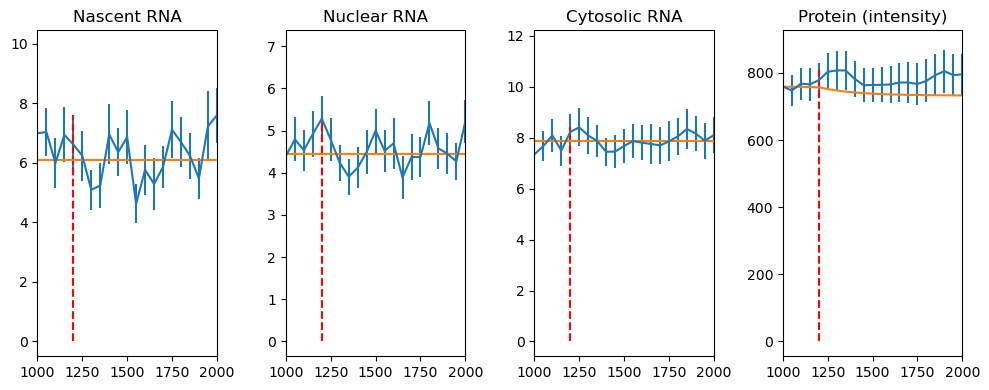

In [2506]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,100,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 4 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, drug_conc=100,path=pathName, model='ODE', ntraj=10)

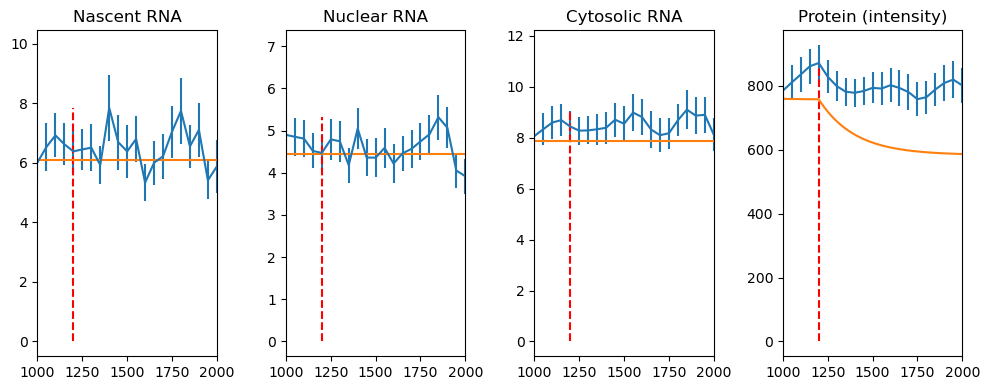

In [2507]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,300,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 4 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict,drug_conc=300, path=pathName, model='ODE', ntraj=10)

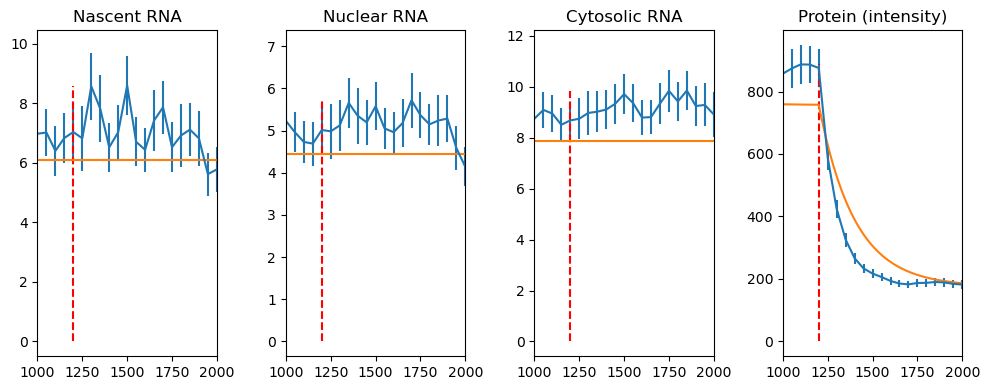

In [2508]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,1000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 4 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict,drug_conc=1000, path=pathName, model='ODE', ntraj=10)

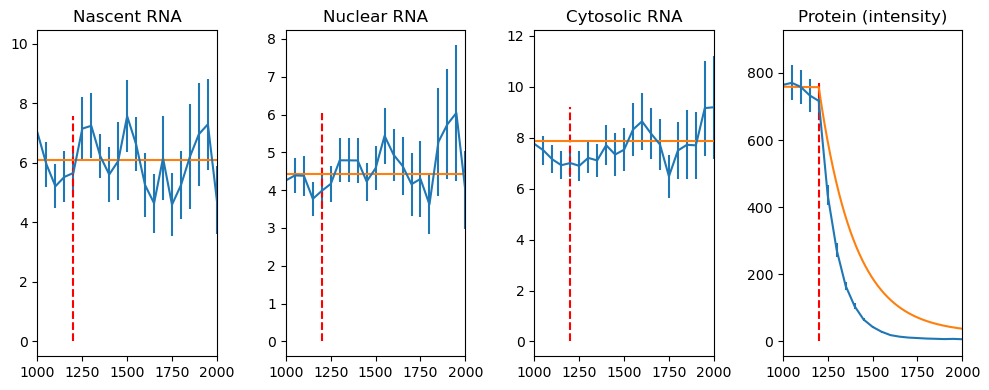

In [2509]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,3000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 4 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict,drug_conc=3000, path=pathName, model='ODE', ntraj=10)

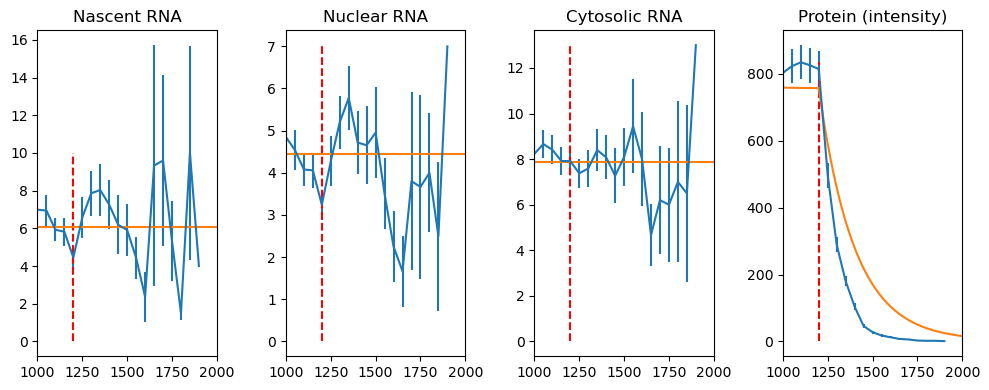

In [2510]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,10000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 4 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName,drug_conc=10000, model='ODE', ntraj=10)

## DRUG 6

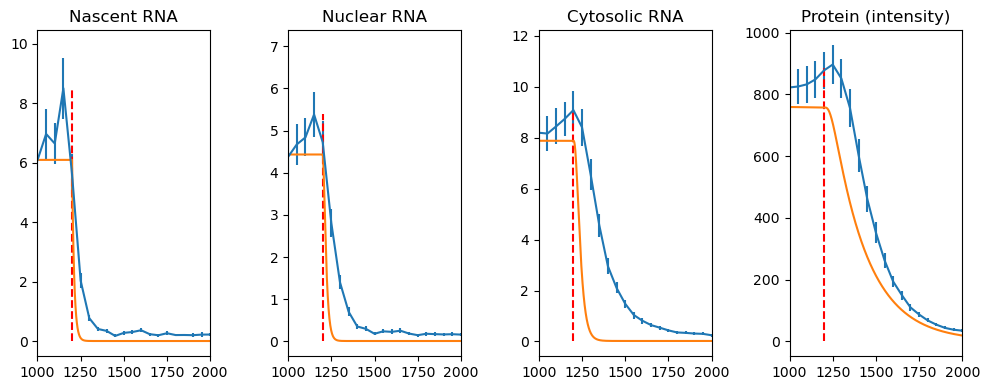

In [2511]:

# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,100,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 6 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

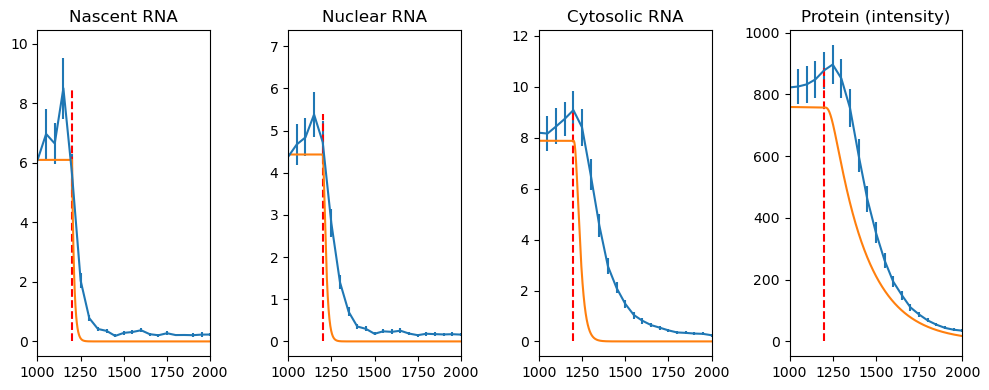

In [2512]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,300,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 6 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

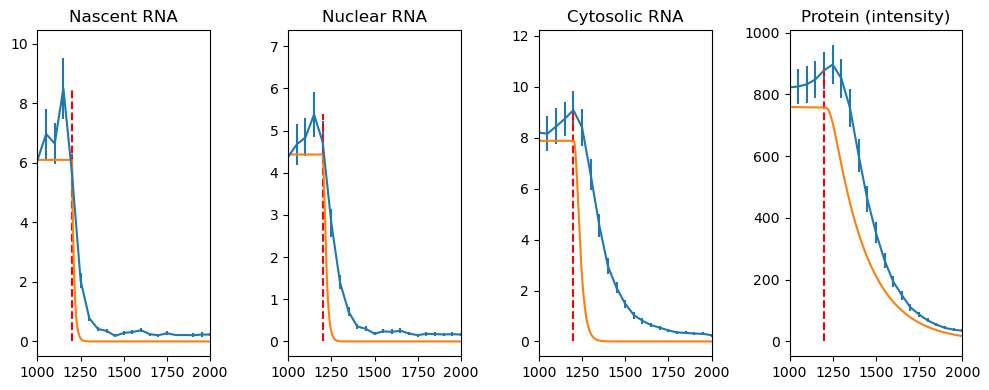

In [2513]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,1000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 6 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

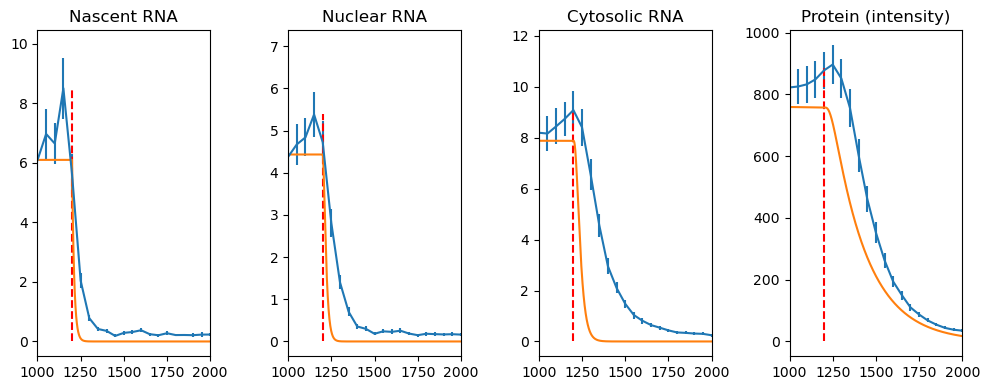

In [2514]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,3000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 6 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

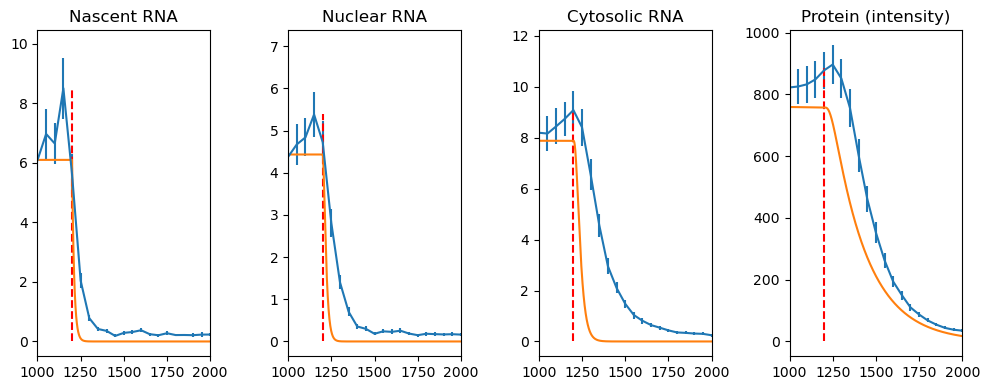

In [2515]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,10000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 6 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

## DRUG 7

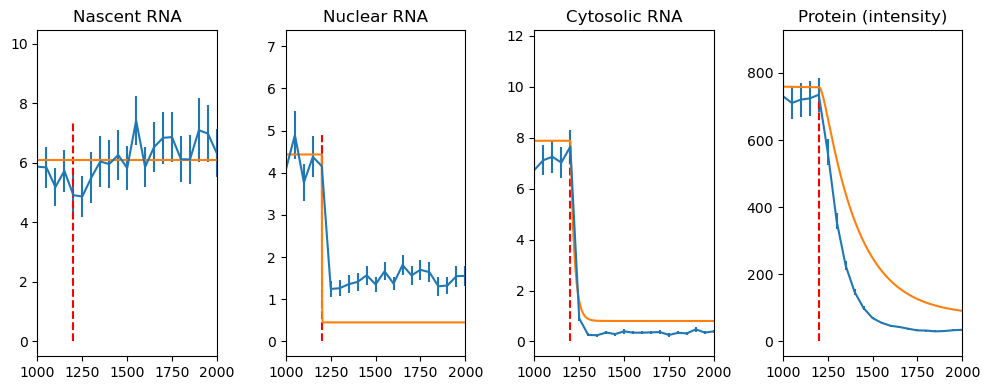

In [2516]:

# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,100,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 7 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

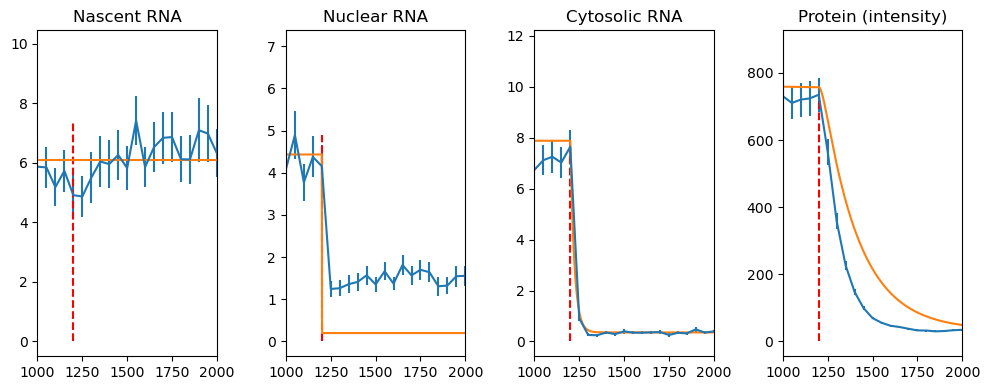

In [2517]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,300,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 7 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

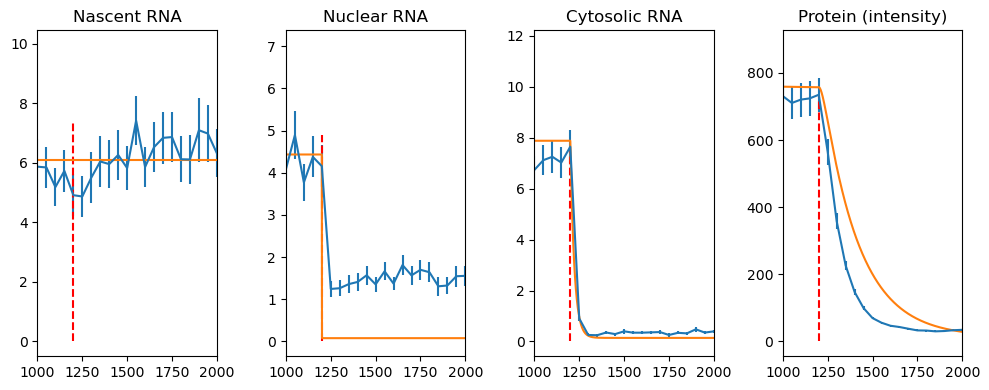

In [2518]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,1000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 7 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

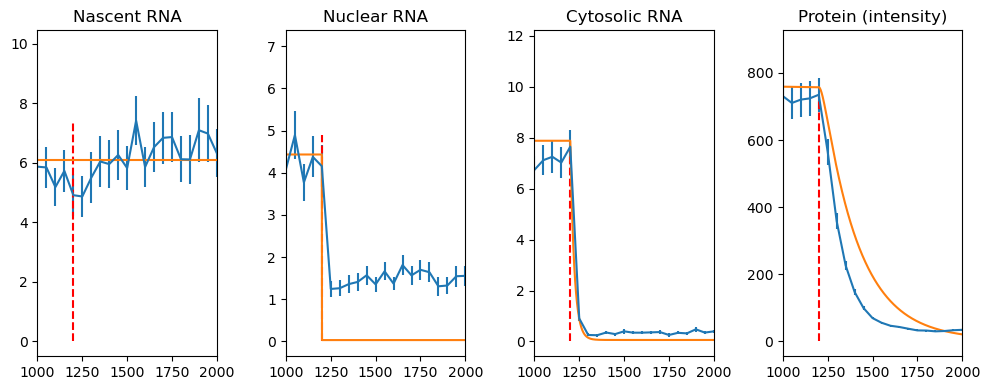

In [2519]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,3000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 7 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

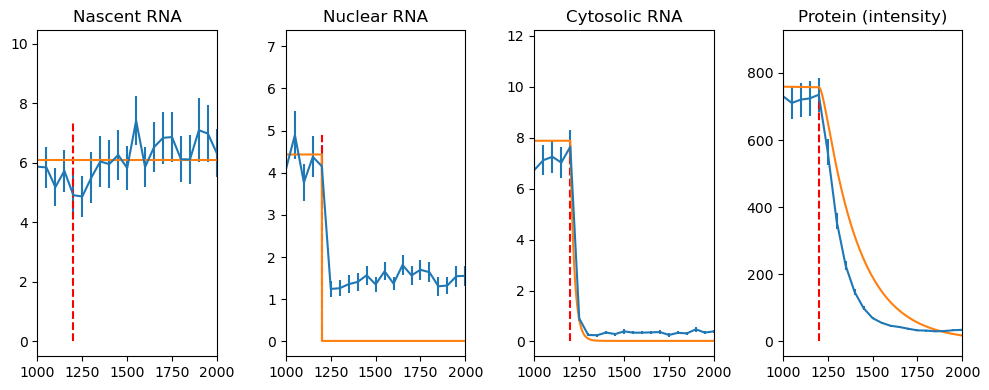

In [2520]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,10000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 7 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

## DRUG 10

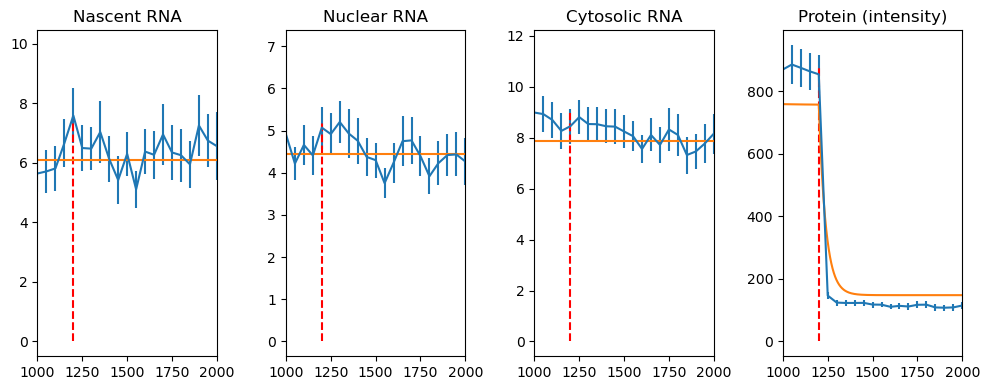

In [2521]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,100,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 10 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

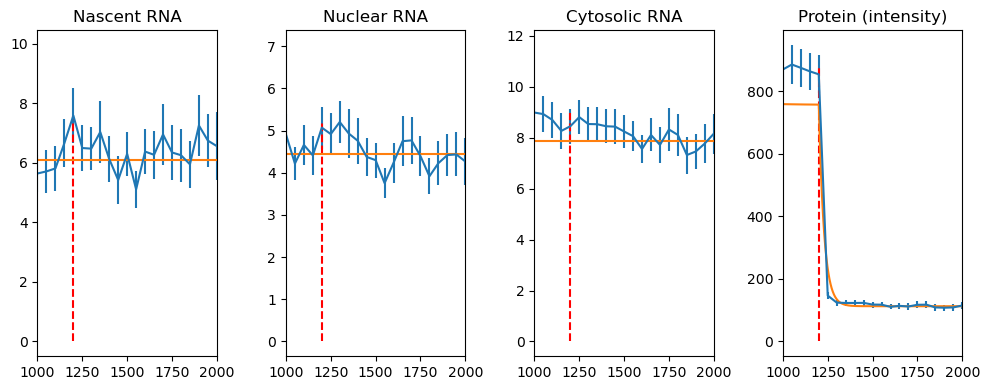

In [2522]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,300,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 10 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

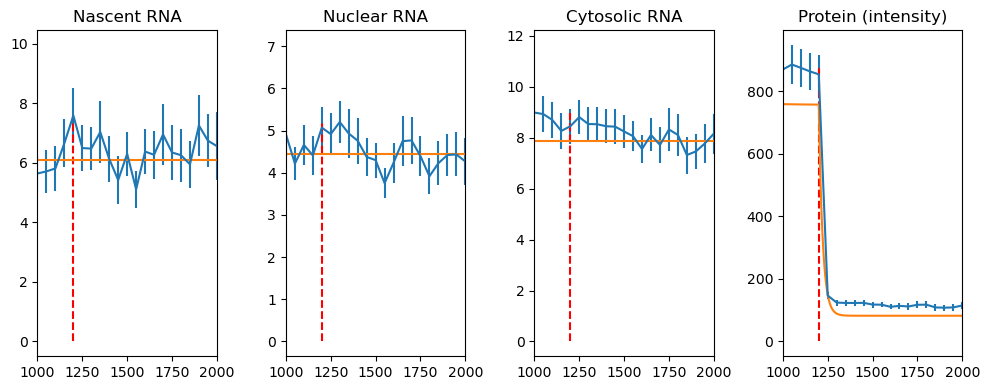

In [2523]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,1000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 10 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

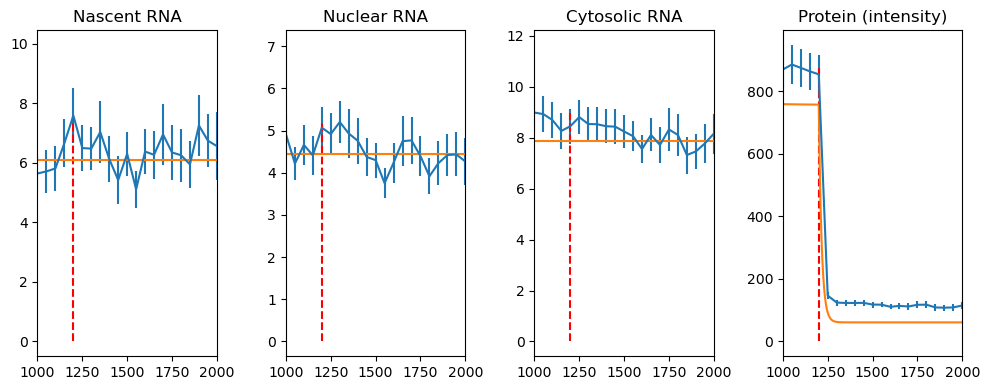

In [2524]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,3000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 10 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)

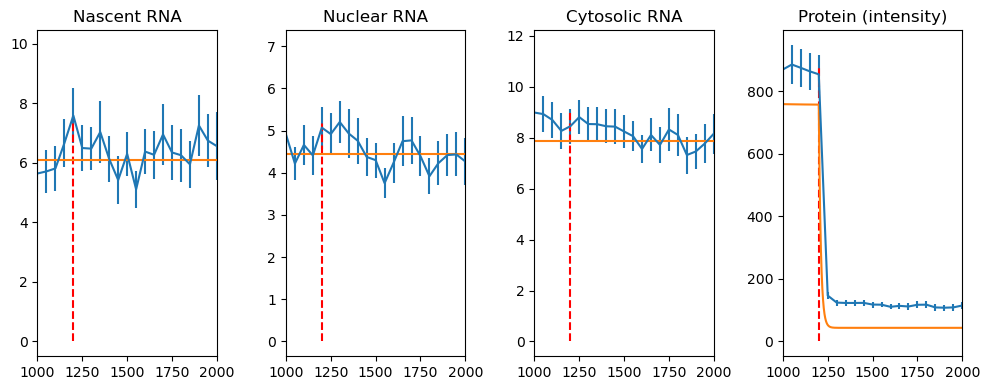

In [2525]:
# Drug concentrations and application times
ti = [np.inf,1200,np.inf]
di = [0,10000,0]
# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 10 # 0 for no drug, 1 for drug 1, 2 for drug 2
compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)